<a href="https://colab.research.google.com/github/nikhilbhide/deep-learning/blob/main/Logistic_Regression_Predicting_Diabetes_Onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

#### Predicting Diabetes Onset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [4]:
# Retrieve data
!wget https://lazyprogrammer.me/course_files/exercises/diabetes.csv

--2021-12-13 13:56:16--  https://lazyprogrammer.me/course_files/exercises/diabetes.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/csv]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    in 0s      

2021-12-13 13:56:17 (116 MB/s) - ‘diabetes.csv’ saved [23873/23873]



In [5]:
# Load data 
df = pd.read_csv("diabetes.csv")

In [12]:
# Take a glance at data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Compute statistical summary of dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# There are two classes. 1 indicates diabetes possibility and 0 the other wise.
df["Outcome"].unique()

array([1, 0])

In [8]:
# Check the data type of dataframe column
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [9]:
# Check for null data. No column is having null data
df.isna().sum()/df.shape[0]

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

In [10]:
def target_classification(df, target):
    fig, ax = plt.subplots(figsize = (6, 6))
    
    labels = df[target].value_counts().index.tolist()
    palette = ["#0EB8F1", "#F1480F", "#971194", "#FEE715", "#101820"]

    ax.pie(df[target].value_counts(), labels = labels, autopct = '%1.2f%%', 
           startangle = 180, colors = palette[: len(labels)])

    ax.set_title(target)
    plt.show()

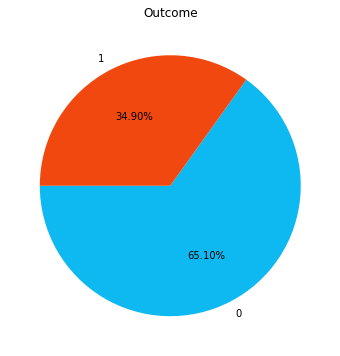

In [16]:
# Number of Non-Diabetic patients is less than Diabetic patients
target_classification(df, "Outcome")

In [11]:
def feature_dist_clas(df, col, hue):
    
    fig, axes = plt.subplots(1, 4, figsize = (25, 5))
    order = sorted(df[hue].unique())
    palette = ["#0EB8F1", "#F1480F", "#971194", "#FEE715", "#101820"]
    
    sns.histplot(x = col, hue = hue, data = df, ax = axes[0], palette = palette[: df[hue].nunique()], edgecolor="black", linewidth=0.5)
    sns.kdeplot(x = col, hue = hue, data = df, fill = True, ax = axes[1], palette = palette[: df[hue].nunique()], linewidth = 2)
    sns.boxplot(y = col, hue = hue, data = df, x = [""] * len(df), ax = axes[2], 
                palette = palette[:len(order)], linewidth = 2, flierprops = dict(marker = "x", markersize = 3.5))
    
    sns.violinplot(y = col, hue = hue, data = df, x = [""] * len(df), ax = axes[3], palette = palette[: df[hue].nunique()])
    
    fig.suptitle("For Feature:  " + col)
    axes[0].set_title("Histogram For Feature " + col)
    axes[1].set_title("KDE Plot For Feature " + col)   
    axes[2].set_title("Boxplot For Feature " + col)   
    axes[3].set_title("Violinplot For Feature " + col)   
    
    for ax in axes:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.1)

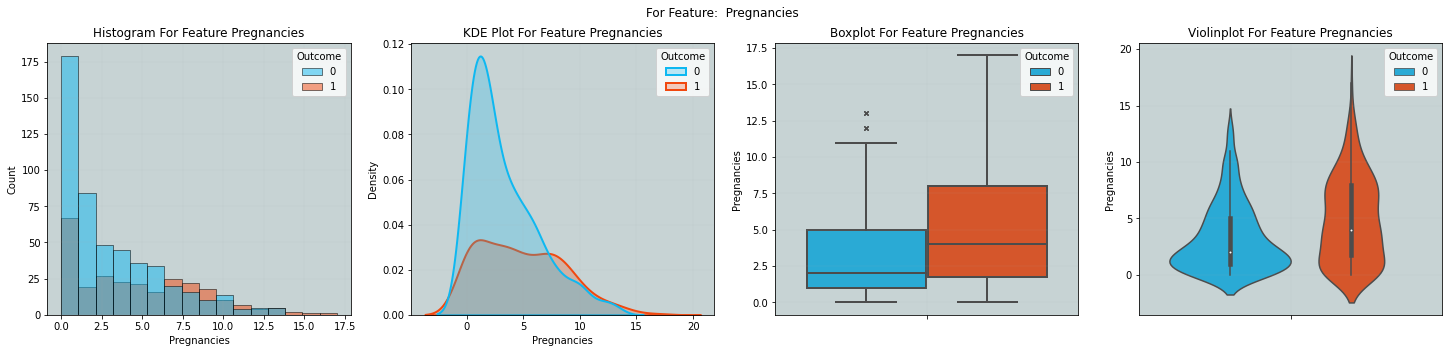

In [12]:
# Higher pregnacies indicate higher risk of diabetes
feature_dist_clas(df,"Pregnancies","Outcome")

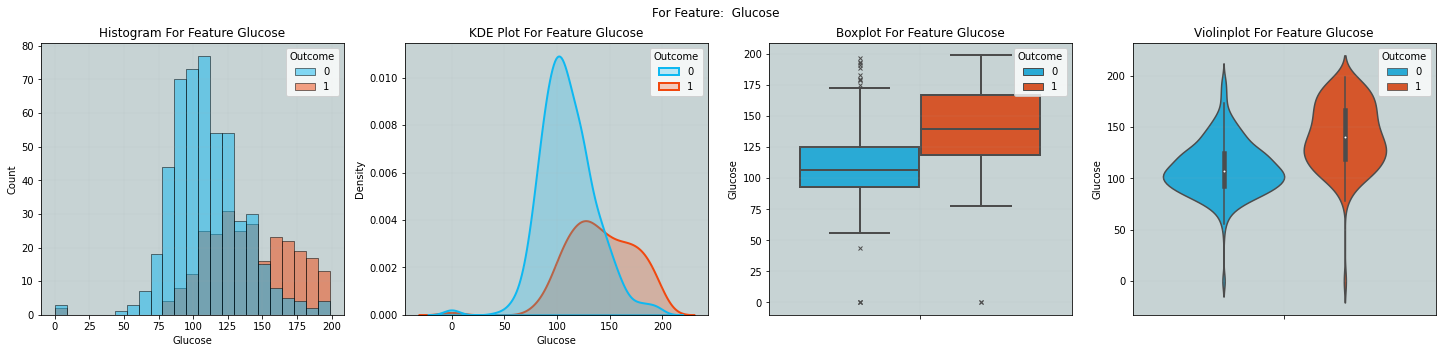

In [13]:
# Higher glucose indicate higher risk of diabetes
feature_dist_clas(df,"Glucose","Outcome")

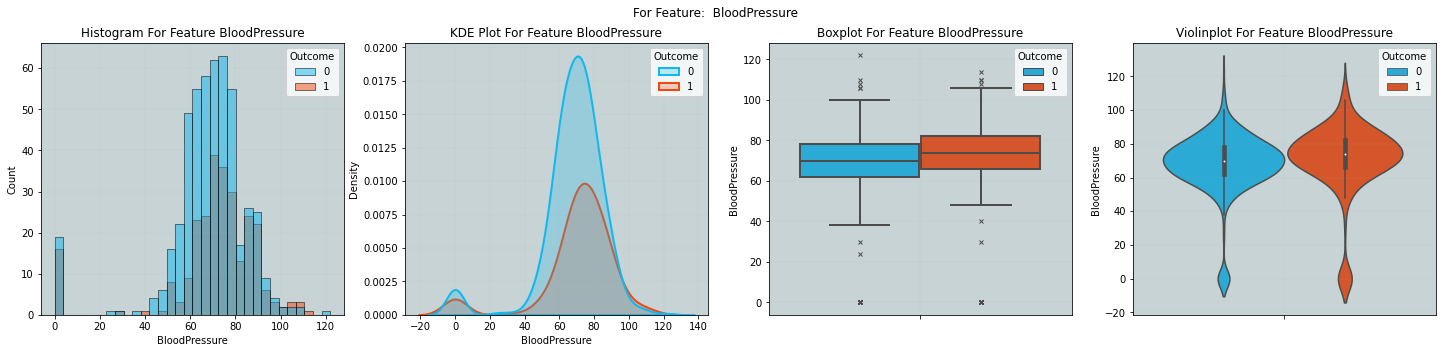

In [14]:
# No interesting correlation between bloodpressure and outcome
feature_dist_clas(df,"BloodPressure","Outcome")

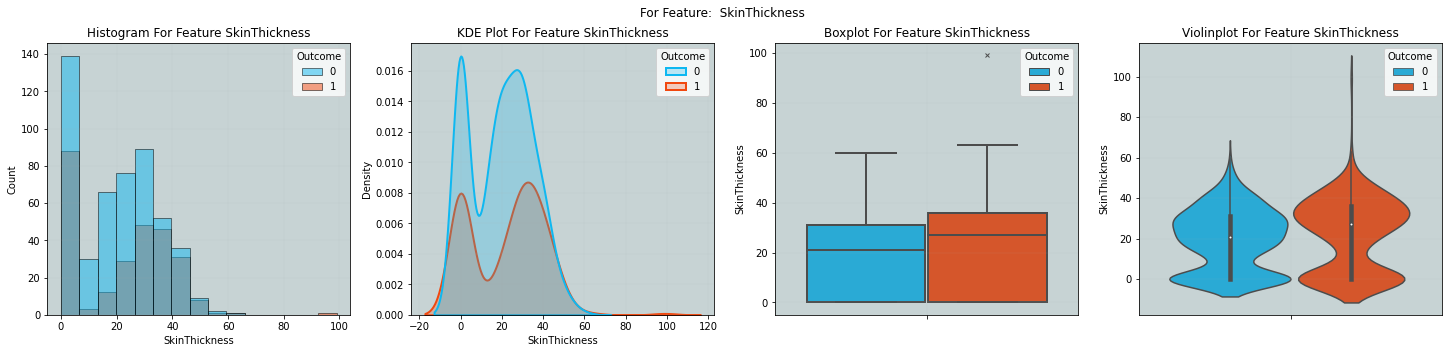

In [15]:
# No interesting correlation between skinthickness and outcome
feature_dist_clas(df,"SkinThickness","Outcome")

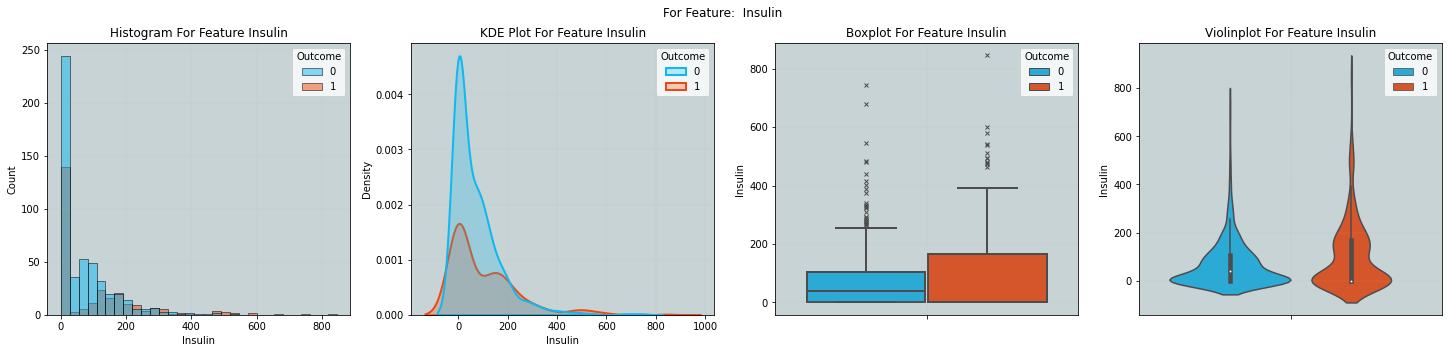

In [16]:
feature_dist_clas(df,"Insulin","Outcome")

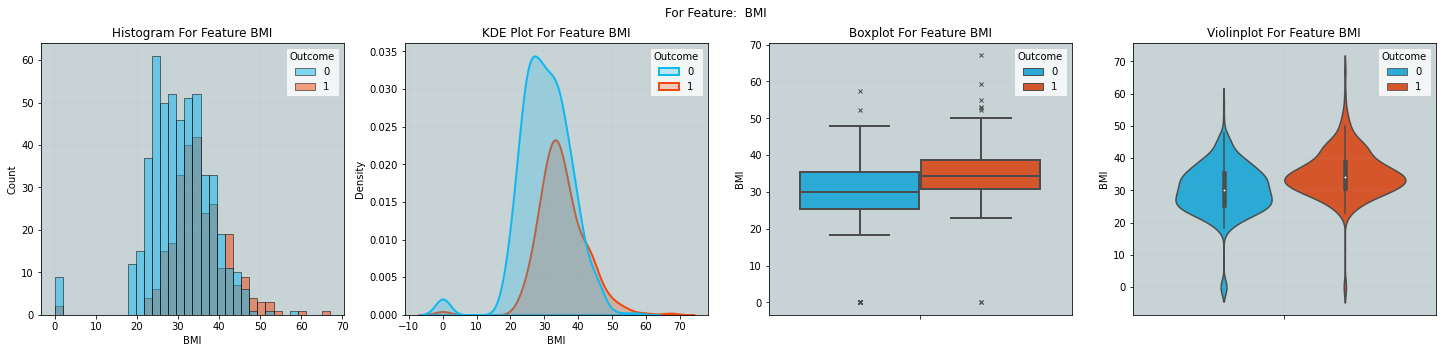

In [17]:
# Higher BMI increases risk of diabetes outcome
feature_dist_clas(df,"BMI","Outcome")

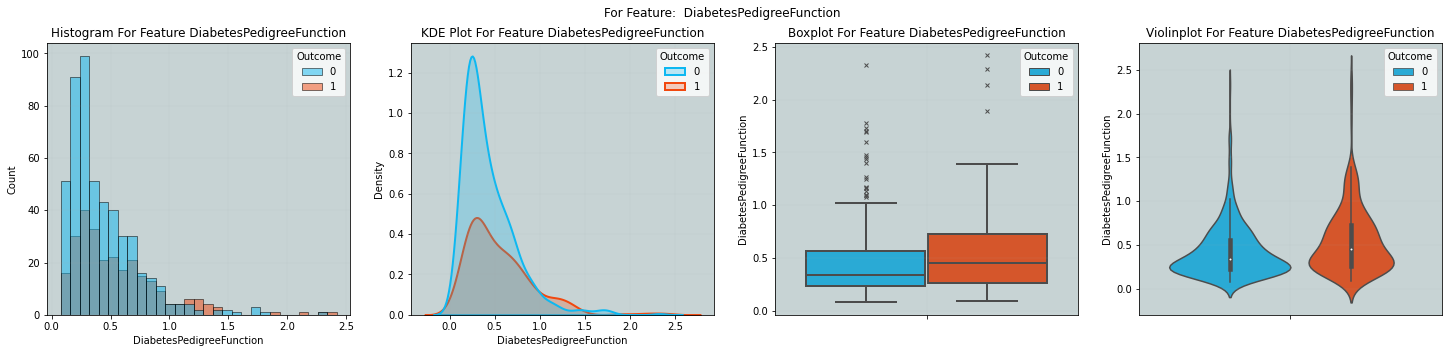

In [18]:
feature_dist_clas(df,"DiabetesPedigreeFunction","Outcome")

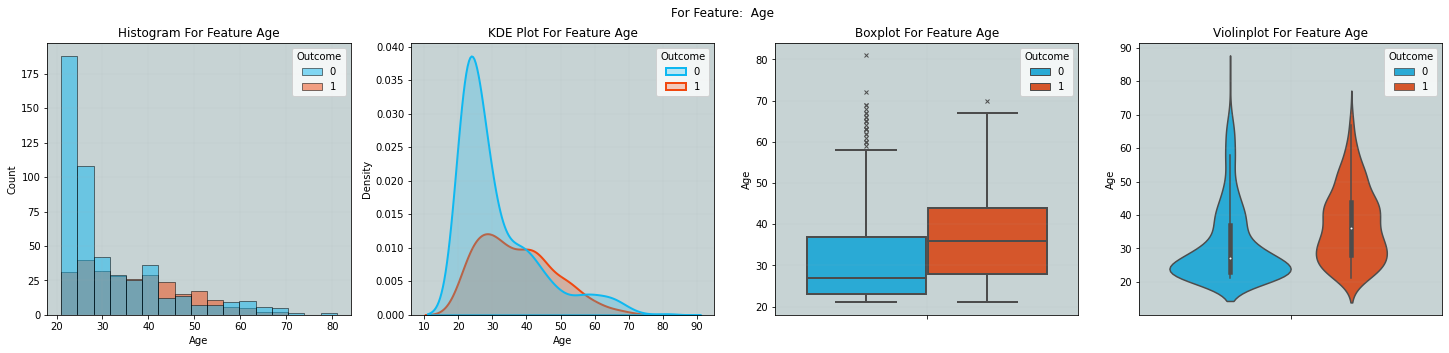

In [19]:
# Risk of diabetes increases after age of 30
feature_dist_clas(df,"Age","Outcome")

In [20]:
# Split data into features and label
X = df.drop('Outcome', 1)
y = df["Outcome"]

In [22]:
# Split data into train and test with test_size as 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [23]:
# Perform standardization on the features so that deep learning model would converge faster
# Standardization makes computations easier and reduces the potential risk of high value features imposing the higher influence on the model
mapper = DataFrameMapper([(X_train.columns, StandardScaler())])
train_features = mapper.fit_transform(X_train.copy(), 4)
train_df = pd.DataFrame(train_features, index=X_train.index, columns=X_train.columns)

test_features = mapper.fit_transform(X_test.copy(), 4)
test_df = pd.DataFrame(test_features, index=X_test.index, columns=X_test.columns)

In [24]:
# Create the train and test dataframes
train_df = pd.concat([train_df, y_train], axis = 1)
test_df = pd.concat([test_df, y_test], axis = 1)

In [25]:
train_df.to_csv("train.csv", index = False)
test_df.to_csv("test.csv", index = False)

In [34]:
# Define the Dataset class for diabetes dataset
class DiabetesDataset(Dataset):
    
    def __init__(self, file):
        df = pd.read_csv(file, dtype = np.float32)
        xy = df.to_numpy()
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:,:-1])
        y = torch.from_numpy(xy[:,-1], )
        self.y_data  = y.type(torch.LongTensor)

        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [35]:
# Create train, valid and test dataloaders

# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

train_data = DiabetesDataset("train.csv")
test_data = DiabetesDataset("test.csv")

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [64]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 16
        hidden_2 = 32
        # Linear layer (features->hidden_1)
        self.fc1 = nn.Linear(8, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> output)
        self.fc3 = nn.Linear(hidden_2, 2)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        # x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [65]:
# Instnatiate criterion and optimizer for training model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [66]:
# number of epochs to train the model
n_epochs = 100
train_losses = []
valid_losses = []
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.706518 	Validation Loss: 0.691481
Validation loss decreased (inf --> 0.691481).  Saving model ...
Epoch: 2 	Training Loss: 0.675688 	Validation Loss: 0.679797
Validation loss decreased (0.691481 --> 0.679797).  Saving model ...
Epoch: 3 	Training Loss: 0.658101 	Validation Loss: 0.657706
Validation loss decreased (0.679797 --> 0.657706).  Saving model ...
Epoch: 4 	Training Loss: 0.635374 	Validation Loss: 0.652677
Validation loss decreased (0.657706 --> 0.652677).  Saving model ...
Epoch: 5 	Training Loss: 0.623156 	Validation Loss: 0.641555
Validation loss decreased (0.652677 --> 0.641555).  Saving model ...
Epoch: 6 	Training Loss: 0.610832 	Validation Loss: 0.636774
Validation loss decreased (0.641555 --> 0.636774).  Saving model ...
Epoch: 7 	Training Loss: 0.601602 	Validation Loss: 0.613106
Validation loss decreased (0.636774 --> 0.613106).  Saving model ...
Epoch: 8 	Training Loss: 0.591351 	Validation Loss: 0.602583
Validation loss decreased (0.61310

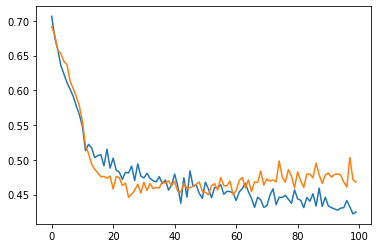

In [67]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(valid_losses, label = "Valid Loss")